In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable as V
import torch.nn.functional as F


# New stuff.
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence

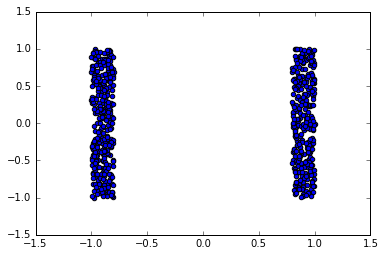

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
r = np.random.random([3000,2]) * 2 - 1.0
# Label points within a circle.
X = np.array([r[i] for i in range(r.shape[0]) if r[i,0] < -0.8 or r[i,0] > 0.8 ] )# and np.linalg.norm(r[i]) > 0.7])
plt.scatter(x =X[:, 0], y = X[:, 1])

In [3]:
LATENT_DIM = 8

# Compute the variational parameters for q
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(2, 200)
        self.linear2 = nn.Linear(200, LATENT_DIM)
        self.linear3 = nn.Linear(200, LATENT_DIM)

    def forward(self, x):
        h = F.relu(self.linear1(x))
        return self.linear2(h), self.linear3(h) 

In [4]:
# Implement the generative model p(x | z)
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(LATENT_DIM, 200)
        self.linear2 = nn.Linear(200, 2)

    def forward(self, z):
        return self.linear2(F.relu(self.linear1(z)))

In [5]:
# VAE using reparameterization "rsample"

class NormalVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(NormalVAE, self).__init__()

        # Parameters phi and computes variational parameters lambda
        self.encoder = encoder

        # Parameters theta, p(x | z)
        self.decoder = decoder
    
    def forward(self, x_src):
        # Example variational parameters lambda
        mu, logvar = self.encoder(x_src)
        
        q_normal = Normal(loc=mu, scale=logvar.mul(0.5).exp())

        # Reparameterized sample.
        z_sample = q_normal.rsample()
        #z_sample = mu
        return self.decoder(z_sample), q_normal        

In [ ]:
BATCH_SIZE = 32

mse_loss = nn.L1Loss(size_average=False)

# Problem setup.
encoder = Encoder()
decoder = Decoder()
vae = NormalVAE(encoder, decoder)

# SGD
learning_rate = 0.02
optim = torch.optim.SGD(vae.parameters(), lr = learning_rate)

NUM_EPOCHS = 50

# Get samples.
p = Normal(V(torch.zeros(BATCH_SIZE, LATENT_DIM)), 
           V(torch.ones(BATCH_SIZE, LATENT_DIM)))


for epoch in range(NUM_EPOCHS):
    # Keep track of reconstruction loss and total kl
    total_loss = 0
    total_kl = 0
    total = 0
    alpha = 1
    for i, t in enumerate(X, BATCH_SIZE):
        if X[i:i+BATCH_SIZE].shape[0] < BATCH_SIZE : continue

        # Standard setup. 
        vae.zero_grad()
        x = V(torch.FloatTensor(X[i: i+BATCH_SIZE] ))

        # Run VAE. 
        out, q = vae(x)
        kl = kl_divergence(q, p).sum()

        # actual loss
        loss = mse_loss(out, x) + alpha * kl 
        loss = loss / BATCH_SIZE

        # record keeping.
        total_loss += mse_loss(out, x).data / BATCH_SIZE
        total_kl += kl.data / BATCH_SIZE
        total += 1
        loss.backward()
        optim.step()
    graph_vae()
    print(i, total_loss[0] / total , total_kl[0] / total)

In [9]:
# 634 1.2236697726779513 0.08741735529016566
# 634 1.1858184814453125 0.10285142969202113
# 634 1.1673569290726273 0.11373414640073423
# 634 1.1217796043113426 0.132163902565285
# 634 1.0838296395760996 0.15316701818395545
# 634 1.0764360215928819 0.16041946411132812
# 634 1.076873779296875 0.1639566209581163
# pictures of 2D std normal samples that gradually move out to the edges

In [12]:
seed_distribution = Normal(V(torch.zeros(BATCH_SIZE, LATENT_DIM)), 
                        V(torch.ones(BATCH_SIZE, LATENT_DIM)))

In [15]:
seed_distribution.sample()[0]

Variable containing:
-0.5953
 1.8301
-0.2908
 0.4485
 1.0575
 0.3450
 1.4554
 1.5685
[torch.FloatTensor of size 8]

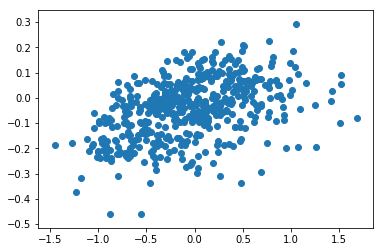

In [7]:
seed_distribution = Normal(V(torch.zeros(BATCH_SIZE, LATENT_DIM)), 
                        V(torch.ones(BATCH_SIZE, LATENT_DIM)))
def graph_vae():
    fig, axs = plt.subplots(1,1)
    all = []
    all_out = []
    for k in range(500):
        seed =  seed_distribution.sample() # batch_size,latent_dim
        x = decoder(seed[0:1] ) # 1,latent_dim -> 1,2
        all.append(x.data[0].numpy())
       
    all = np.array(all)
    axs.scatter(all[:, 0], all[:, 1])

graph_vae()

In [9]:
# unlike the pset, x is 2-dimensional and latent z is 8-dimensional
print(encoder(V(torch.FloatTensor([-1, 0])) )[0] )
print(encoder(V(torch.FloatTensor([1, 0])) )[0])

Variable containing:
-0.0096
 0.6418
-0.0016
 0.0111
-0.0200
-0.0055
-0.0091
 0.0317
[torch.FloatTensor of size (8,)]

Variable containing:
-0.0031
-0.5853
-0.0035
-0.0072
 0.0119
 0.0182
 0.0068
-0.0391
[torch.FloatTensor of size (8,)]



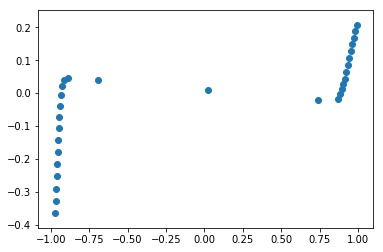

In [10]:
z = V(torch.zeros(8))

all = []
for k in np.linspace(-3, 3, 30):
    seed = seed_distribution.sample()
    # missing z=seed?
    z[1] = k
    x = decoder(z)
    all.append(x.data.numpy())
all = np.array(all)
plt.scatter(all[:, 0], all[:, 1])

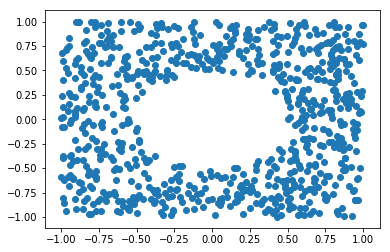

In [21]:
# GAN
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
r = np.random.random([1000,2]) * 2 - 1.0
# Label points within a circle.
X = np.array([r[i] for i in range(r.shape[0]) if np.linalg.norm(r[i]) > 0.5 ])
plt.scatter(x =X[:, 0], y = X[:, 1])

In [25]:
LATENT_DIM = 32
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(LATENT_DIM, 100)
        self.linear2 = nn.Linear(100, 2)
    def forward(self, z):
        return self.linear2(F.relu(self.linear1(z))) 

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(2, 100)
        self.linear2 = nn.Linear(100, 1)

    def forward(self, point):
        return F.sigmoid(self.linear2(F.relu(self.linear1(point))))


In [27]:
G = Generator()
D = Discriminator()
learning_rate = 0.01
optim_gen = torch.optim.SGD(G.parameters(), lr=learning_rate)
optim_disc = torch.optim.SGD(D.parameters(), lr=learning_rate)
seed_distribution = Normal(V(torch.zeros(BATCH_SIZE, LATENT_DIM)), 
                           V(torch.ones(BATCH_SIZE, LATENT_DIM)))       

In [ ]:
for epoch in range(50):
    total_gen_loss = 0
    total_disc_loss = 0
    for i, t in enumerate(X, BATCH_SIZE):
        if X[i:i+BATCH_SIZE].shape[0] < BATCH_SIZE : continue

        # Grad real
        # -E[log(D(x))]
        optim_disc.zero_grad()
        optim_gen.zero_grad()
        x_real = V(torch.FloatTensor(X[i:i+BATCH_SIZE]))
        d = D(x_real)
        loss_a = 0.5 * -d.log().mean()
        loss_a.backward()
        
        # Grad fake
        # -E[log(1 - D(G(z)) )]
        seed = seed_distribution.sample()
        x_fake = G(seed)
        d = D(x_fake.detach())        
        loss_b = 0.5 * -(1 - d + 1e-10).log().mean()
        loss_b.backward()
        optim_disc.step()
        total_disc_loss += loss_a.data[0] + loss_b.data[0]

        # Grad generator
        # E[log(1 - D(G(z)))]
        optim_disc.zero_grad()
        # No detach here.
        d = D(x_fake)
        loss_c = (1 - d + 1e-10).log().mean()
        #loss_c = -(d + 1e-10).log().mean()
        loss_c.backward()        
        optim_gen.step()    
        total_gen_loss += loss_c.data[0]
    graph()
    print(i, total_disc_loss /  X.shape[0], total_gen_loss / X.shape[0])

In [16]:
# 805 0.6228364937835269 -0.6256048729792429
# 805 0.6245231784360353 -0.6139289883064053
# 805 0.6199491622374039 -0.6103112843147543
# 805 0.6288603526523255 -0.6256580240350669
# 805 0.6261372029088265 -0.6216000795210362
# 805 0.6270622593718905 -0.6234798616987174
# 805 0.6248599717860382 -0.6206227497845042
# blue and red moving around with each other

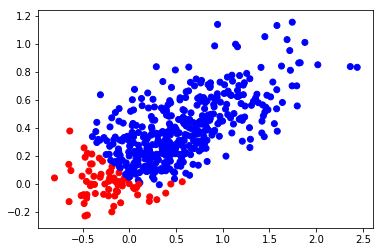

In [16]:
def graph():
    fig, axs = plt.subplots(1,1)
    all = []
    all_out = []
    for k in range(500):
        seed = seed_distribution.sample()
        x_fake = G(seed[0:1])
        out = D(x_fake)        
        all.append(x_fake.data[0].numpy())
        all_out.append(out)
    all = np.array(all)
    out = np.array(all_out)
    axs.scatter(all[:, 0], all[:, 1], color=["blue" if c < 0.5 else "red" for c in out])

graph()

In [30]:
import torchtext.data as data
import torchtext.datasets as datasets
from torchtext.vocab import GloVe

This part is slow to run on CPU. But it shows the setup for a Miao (2016) type VAE over text. Here we use powerful encoder in the form of a LSTM. But use a very simple generative model that predicts a set of works (in binary represenation) as the output. The aim is that the latent variable should learn something akin to a topic about the words themseles. 

In [31]:
TEXT = data.Field(lower=True, include_lengths=True, batch_first=True)
LABEL = data.Field(sequential=False)

# make splits for data
train, test = datasets.TREC.splits(TEXT, LABEL, fine_grained=True)
TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=100))
LABEL.build_vocab(train)

In [32]:
WORD_DIM = 100
LATENT_DIM = 32
num_embeddings = len(TEXT.vocab)

# LSTM Encoder / Inference Network
class Encoder(nn.Module):
    def __init__(self, num_embeddings):
        super(Encoder, self).__init__()
        self.emb_layer = nn.Embedding(embedding_dim=WORD_DIM, 
                                      num_embeddings=num_embeddings)
        self.emb_layer.weight.data = TEXT.vocab.vectors.clone()
        self.enc_layer = nn.LSTM(input_size=WORD_DIM, hidden_size=WORD_DIM)
        self.mu_layer = nn.Linear(WORD_DIM, LATENT_DIM)
        self.logvar_layer = nn.Linear(WORD_DIM, LATENT_DIM)
        
    def forward(self, src):
        emb = self.emb_layer(src)
        output, _  = self.enc_layer(emb)
        final = output[:, -1]
        mu = self.mu_layer(final)
        logvar = self.logvar_layer(final)
        return mu, logvar

In [33]:
# Bag-of-Word Generative Model
class Decoder(nn.Module):
    def __init__(self, num_embeddings):
        super(Decoder, self).__init__()
        self.layer1 = nn.Linear(LATENT_DIM, 200)
        self.layer2 = nn.Linear(200, num_embeddings)
    def forward(self, hidden):
        return self.layer2(F.relu(self.layer1(hidden)))


In [53]:
BATCH_SIZE = 32
train_iter, test_iter = data.BucketIterator.splits(
    (train, test), batch_size=BATCH_SIZE, device=-1)
bce = nn.BCEWithLogitsLoss(size_average=False)
encoder = Encoder(len(TEXT.vocab))
decoder = Decoder(len(TEXT.vocab))
vae = NormalVAE(encoder, decoder)
learning_rate = 0.01
optim = torch.optim.SGD(vae.parameters(), lr = learning_rate)
#optim = torch.optim.Adam(vae.parameters(), lr = learning_rate)
NUM_EPOCHS = 50
p = Normal(V(torch.zeros(BATCH_SIZE, LATENT_DIM)), V(torch.ones(BATCH_SIZE, LATENT_DIM)))

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    total_kl = 0
    total = 0
    alpha = 1
    for i, t in enumerate(train_iter):
        if t.label.size(0) != BATCH_SIZE : continue
        vae.zero_grad()
        x, _ = t.text
        out, q = vae(x)
        kl = kl_divergence(q, p).sum()
        target = torch.zeros(BATCH_SIZE, len(TEXT.vocab)).float()
        for b in range(BATCH_SIZE):
            target[b][t.text[0].data[b]] =  1   
        loss = bce(out.view(-1), V(target.view(-1) ) ) + alpha * kl 
        loss = loss / BATCH_SIZE
        
        total_loss += bce(out.view(-1), V(target.view(-1) ) ).data / BATCH_SIZE
        total_kl += kl.data / BATCH_SIZE
        total += 1
        loss.backward()
        optim.step()
    print(i, total_loss[0] / total , total_kl[0] / total)

KeyboardInterrupt: 

In [3]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
train_dataset = datasets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = datasets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

In [4]:
print(len(train_dataset))
print(len(test_dataset))
print(train_dataset[0][0].shape) # pixels
train_dataset[0][1] # label (which digit it is)
# train_dataset is a list of tuples. first elt is 1*28*28, second elt is label

60000
10000
torch.Size([1, 28, 28])


5

In [40]:
torch.manual_seed(3435)
train_img = torch.stack([torch.bernoulli(d[0]) for d in train_dataset])
train_label = torch.LongTensor([d[1] for d in train_dataset])
test_img = torch.stack([torch.bernoulli(d[0]) for d in test_dataset])
test_label = torch.LongTensor([d[1] for d in test_dataset])
# print(train_img[0])
print(train_img.size(), train_label.size(), test_img.size(), test_label.size())

torch.Size([60000, 1, 28, 28]) torch.Size([60000]) torch.Size([10000, 1, 28, 28]) torch.Size([10000])


In [27]:
# MNIST does not have an official train dataset. So we will use the last 10000 training points as your validation set.
val_img = train_img[-10000:].clone()
val_label = train_label[-10000:].clone()
train_img = train_img[:-10000] # hey this should be -10000 right?
train_label = train_label[:-10000]
train = torch.utils.data.TensorDataset(train_img, train_label)
val = torch.utils.data.TensorDataset(val_img, val_label)
test = torch.utils.data.TensorDataset(test_img, test_label)
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

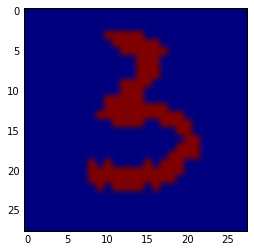

In [50]:
img, label = next(iter(train_loader))
print(img.size(),label.size())
x = img.squeeze(1)
j = x[0].numpy()
plt.imshow(j)
plt.imshow(j.flatten().reshape(28,28))
x = x.view(-1,784)
x = x.view(-1,28,28)
j = x[0].numpy()
plt.imshow(j)